# 🎬 **MOVIE GENRE CLASSIFICATION USING MACHINE LEARNING**  
#A full pipeline including data loading, exploration, preprocessing, training, and evaluation.


###  Setup: Install and Import Required Libraries  


In [ ]:
from IPython.display import clear_output
!pip install catboost
!pip install xgboost
!pip install scikit-learn
clear_output()

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud
from scipy.sparse import hstack
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
%matplotlib inline


# LOADING THE DATA

---

#### 1. In this phase, we import the raw dataset into the workspace, check its shape and structure, and preview the first few rows to understand what kind of data we are working with.

In [ ]:
# Loading the dataset
df = pd.read_csv("/content/drive/MyDrive/datasets/fullDataset.csv")

# Printing the Dimensions and Info of the dataset
print(df.shape)
df.info()

(108414, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108414 entries, 0 to 108413
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   ID           108414 non-null  int64  
 1   Title        108414 non-null  object 
 2   Year         99682 non-null   float64
 3   Genre        108414 non-null  object 
 4   Description  108414 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 4.1+ MB


In [ ]:
# Showing the first 5 rows of the dataset
df.head()

,ID,Title,Year,Genre,Description
0,1,Oscar et la dame rose,2009.0,drama,Listening in to a conversation between his doc...
1,2,Cupid,1997.0,thriller,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful",1980.0,adult,As the bus empties the students for their fiel...
3,4,The Secret Sin,1915.0,drama,To help their unemployed father make ends meet...
4,5,The Unrecovered,2007.0,drama,The film's title refers not only to the un-rec...


# 📊 Exploratory Data Analysis (EDA)
------------

####2. Here, we explore the dataset to understand its key characteristics: we check the balance of the target variable, visualize word frequencies, examine text lengths, and look for missing values, duplicates, or unusual patterns.

Target Distribution:


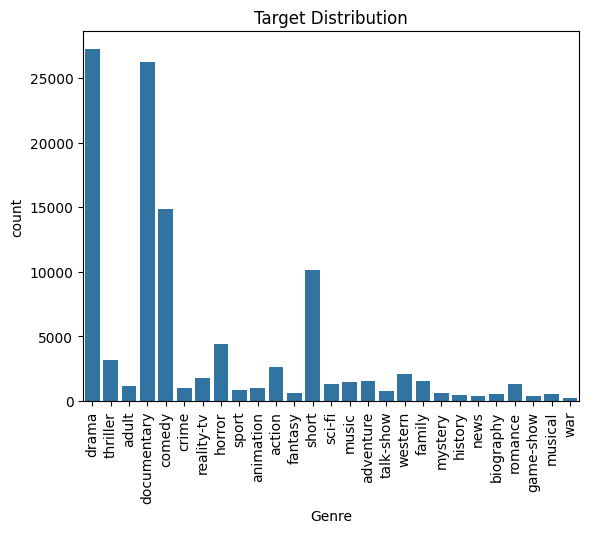

In [ ]:
# 1. Is the target imbalanced?
def check_target_imbalance(df, target_column):
    print("Target Distribution:")
    sns.countplot(x=df[target_column])
    plt.xticks(rotation=90)
    plt.title("Target Distribution")
    plt.show()

check_target_imbalance(df, "Genre")

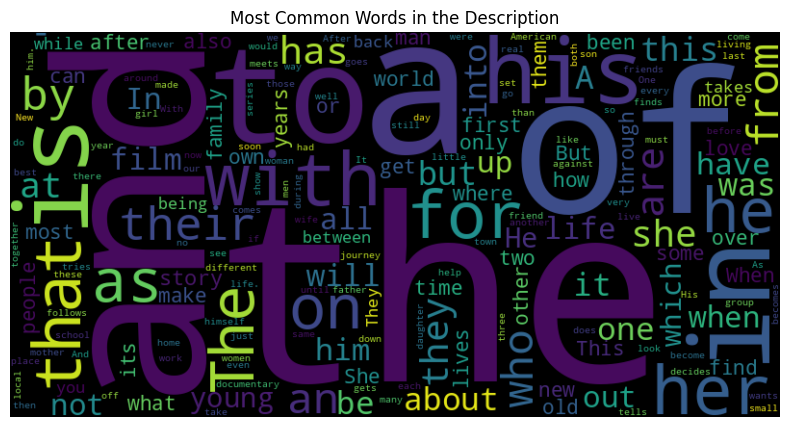

In [ ]:
# 2. showing The Most Common Words in the Description
all_words = ' '.join(df['Description'].astype(str)).split()
word_freq = Counter(all_words)
wc = WordCloud(width=800, height=400).generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in the Description')
plt.show()

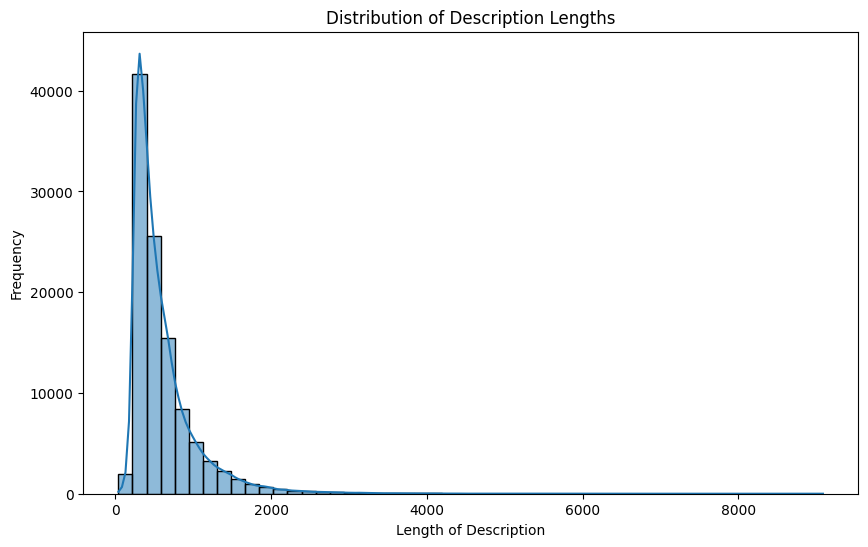

In [ ]:
# 3. Text Length Distribution
df['text_length'] = df['Description'].astype(str).apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribution of Description Lengths')
plt.xlabel('Length of Description')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# 4. Do we have missing values?
def check_missing_values(df):
    missing_values = df.isnull().sum()
    print("Missing Values per Column:")
    print(missing_values[missing_values > 0])
    if missing_values.any():
        print("\nHandle Missing Values as needed.")
    else:
        print("\nNo Missing Values Found.")

check_missing_values(df)

Missing Values per Column:
Year    8732
dtype: int64

Handle Missing Values as needed.


In [ ]:
# 5. Do we have categorical columns?
def encode_categorical_columns(df):
    categorical_cols = df.select_dtypes(include=["object"]).columns
    print("Categorical Columns:", list(categorical_cols))

label_encoders = encode_categorical_columns(df)

Categorical Columns: ['Title', 'Genre', 'Description']


In [ ]:
# 6. Do we have duplicate samples?
def check_duplicates(df):
    duplicates = df.duplicated().sum()
    print(f"Number of Duplicate Samples: {duplicates}")
    if duplicates > 0:
        print("Dropping Duplicates...")
        df.drop_duplicates(inplace=True)
        print("Duplicates Dropped.")
    else:
        print("No Duplicate Samples Found.")

check_duplicates(df)

Number of Duplicate Samples: 0
No Duplicate Samples Found.


# PREPROCESSING
---

#### 2. We clean and prepare the dataset for modeling by handling missing values, removing irrelevant or inconsistent data, encoding categorical labels, normalizing numeric features, and engineering new features to improve model performance.

In [ ]:
# Showing the first 5 rows before preprocessing
df.head()

,ID,Title,Year,Genre,Description,text_length
0,1,Oscar et la dame rose,2009.0,drama,Listening in to a conversation between his doc...,545
1,2,Cupid,1997.0,thriller,A brother and sister with a past incestuous re...,183
2,3,"Young, Wild and Wonderful",1980.0,adult,As the bus empties the students for their fiel...,649
3,4,The Secret Sin,1915.0,drama,To help their unemployed father make ends meet...,1081
4,5,The Unrecovered,2007.0,drama,The film's title refers not only to the un-rec...,624


### 2.1 CLEANING THE DATASET


In [ ]:
# Drop rows with null values
df = df.dropna()

# Clean up the 'Genre' column (remove leading/trailing spaces)
df.loc[:, 'Genre'] = df['Genre'].str.strip()


# Remove rows where 'Year' is marked as 'Unknown'
df = df[df['Year'] != 'Unknown']

# Convert 'Year' column to integer type
df['Year'] = df['Year'].astype(int)

# Drop the ID column
df.drop('ID',axis=1, inplace=True)

# Reset the INdex
df.reset_index(drop=True, inplace=True)

# Display DataFrame info summary
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99682 entries, 0 to 99681
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        99682 non-null  object
 1   Year         99682 non-null  int64 
 2   Genre        99682 non-null  object
 3   Description  99682 non-null  object
 4   text_length  99682 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 3.8+ MB


In [ ]:
#cleaning the Description
def clean_text(text):
  # convert to lower case
  text = text.lower()
  #remove URL
  text = re.sub(r'http\S+|www\.\S+', '', text)
  #remove html tags
  text = re.sub(r'<.*?>', '', text)
  #remove any thing not letter or space
  text = re.sub(r'[^a-zA-Z0-9\s\-\']', '', text)
  #replace all spaces into one space
  text = re.sub(r'\s+', ' ', text).strip()
  #remove stop words
  tokens = [w for w in text.split()]
  return " ".join(tokens)
#appling the clean function
df['Description'] = df['Description'].apply(clean_text)


### 2.2 FILTRING TO INCLUDE THE TOP 3 GENRES

In [ ]:
#filtering only the top 5 classes
fdf = df[df['Genre'].isin(['comedy','drama','documentary'])].copy()
#reseting the index
fdf.reset_index(drop = True, inplace = True)
fdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63687 entries, 0 to 63686
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        63687 non-null  object
 1   Year         63687 non-null  int64 
 2   Genre        63687 non-null  object
 3   Description  63687 non-null  object
 4   text_length  63687 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.4+ MB


### 2.3 ADDING MORE FEATURES

In [ ]:
# This will specify an uper and a lowr bound for the Description with 5 and 200 as lower and uper
fdf['desc_len'] = fdf['Description'].apply(lambda x : len(x.split()))
fdf['tit_len'] = fdf['Title'].apply(lambda x : len(x.split()))
lower  = 10
fdf = fdf[(fdf['desc_len']>=lower) ]

### 2.4 VISUALISING PROCESSED DATASET


Target Distribution:


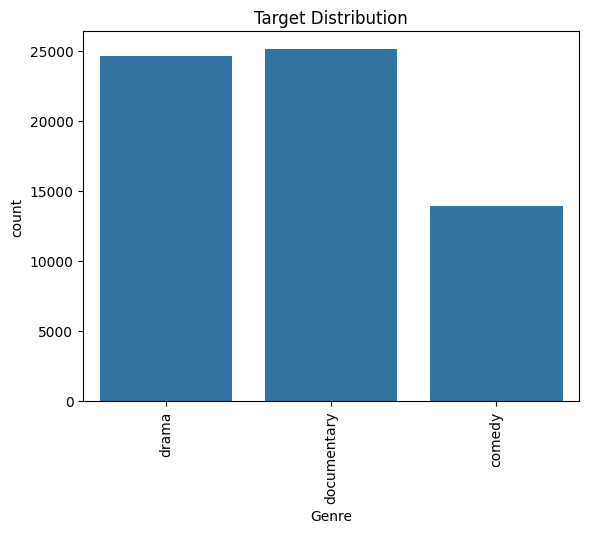

In [ ]:
# 1. Genre Distribution
check_target_imbalance(fdf, "Genre")

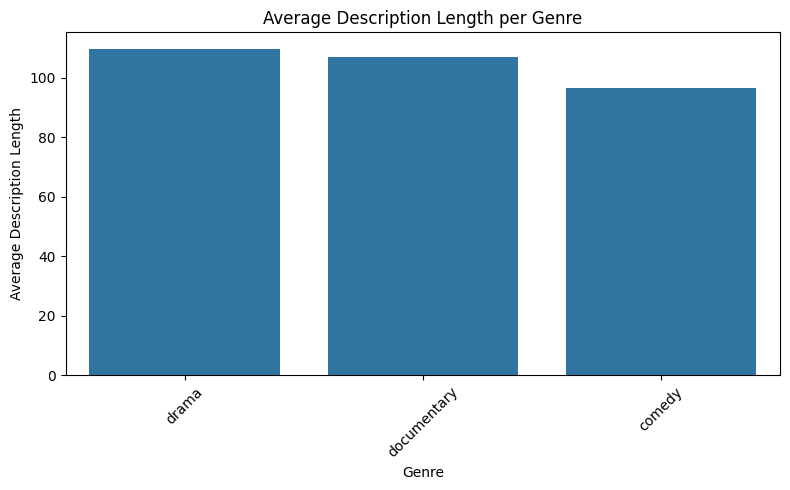

In [ ]:
# 2. Description Length per Genre (Boxplot)
mean_desc = fdf.groupby('Genre')['desc_len'].mean().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x=mean_desc.index, y=mean_desc.values)
plt.title('Average Description Length per Genre')
plt.xlabel('Genre')
plt.ylabel('Average Description Length')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


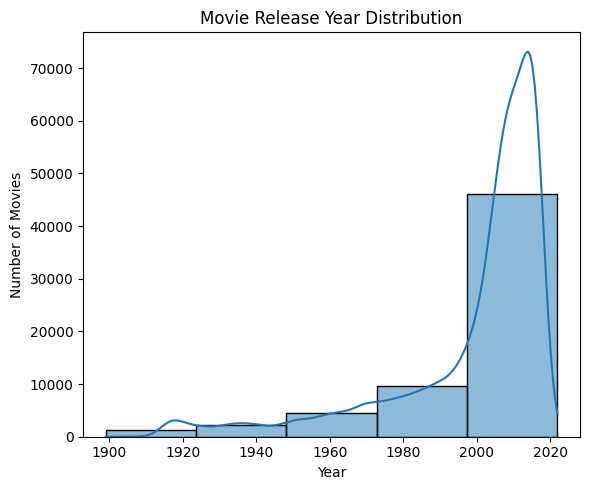

In [ ]:
# 3. Movie Release Year Distribution
plt.figure(figsize=(6, 5))
sns.histplot(data=fdf, x='Year', bins=5, kde=True)
plt.title('Movie Release Year Distribution')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.tight_layout()
plt.show()

### 2.5 NORMLIZING NUMERICAL DATA

In [ ]:
# Selecting numerical columns
numircal_col = fdf.select_dtypes(include = ["int64"]).columns.tolist()
print(numircal_col)

# Normlizing the Selected columns
scaler = MinMaxScaler()
fdf[numircal_col] = scaler.fit_transform(fdf[numircal_col]).copy()


['Year', 'text_length', 'desc_len', 'tit_len']


### 2.6 ENCODING THE LABELS

In [ ]:
# Encoding the label
label_encoder = preprocessing.LabelEncoder()
fdf['Genre'] = label_encoder.fit_transform(fdf["Genre"])

In [ ]:
# Showing the first 5 rows after preprocessing
fdf.head()

,Title,Year,Genre,Description,text_length,desc_len,tit_len
0,Oscar et la dame rose,0.894309,2,listening in to a conversation between his doc...,0.053431,0.050307,0.102564
1,The Secret Sin,0.130081,2,to help their unemployed father make ends meet...,0.112848,0.111043,0.051282
2,The Unrecovered,0.878049,2,the film's title refers not only to the un-rec...,0.062188,0.058896,0.025641
3,Quality Control,0.910569,1,quality control consists of a series of 16mm s...,0.171267,0.152147,0.025641
4,"""Pink Slip""",0.894309,0,in tough economic times max and joey have all ...,0.031150,0.032515,0.025641


# TRANING AND EVALUTION

---

#### 4. In this final stage, we train different machine learning models on the processed data, validate their performance using accuracy, loss, and confusion matrices, and compare the results to choose the best-performing model.


## Prepareing The Data

In [ ]:
# Prepare Data
fdf = fdf.copy()

# Combine features into a single text field (WITHOUT Year to avoid leakage)
fdf.loc[:, "full_text"] = (
    fdf["Title"] + " " +
    fdf["Description"]
)

# Features and labels
X = fdf[["full_text","Year","desc_len",'tit_len']]
y = fdf["Genre"]


In [ ]:
#@title TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=1000)
X_text = tfidf.fit_transform(fdf['full_text'])


##  Model 1 -  CATBOOST



 Catboost 

0:	learn: 0.7869849	test: 0.7998534	best: 0.7998534 (0)	total: 20.7ms	remaining: 41.3s
50:	learn: 0.8081608	test: 0.8204752	best: 0.8208940 (48)	total: 694ms	remaining: 26.5s
100:	learn: 0.8167523	test: 0.8266513	best: 0.8266513 (100)	total: 1.26s	remaining: 23.6s
150:	learn: 0.8217546	test: 0.8297917	best: 0.8304198 (139)	total: 1.76s	remaining: 21.6s
200:	learn: 0.8253438	test: 0.8309432	best: 0.8312572 (195)	total: 2.29s	remaining: 20.5s
250:	learn: 0.8283048	test: 0.8327227	best: 0.8327227 (250)	total: 2.79s	remaining: 19.5s
300:	learn: 0.8314902	test: 0.8334555	best: 0.8336648 (293)	total: 3.33s	remaining: 18.8s
350:	learn: 0.8341371	test: 0.8341882	best: 0.8347116 (324)	total: 4.28s	remaining: 20.1s
400:	learn: 0.8363355	test: 0.8347116	best: 0.8355490 (373)	total: 6.56s	remaining: 26.1s
bestTest = 0.8355490422
bestIteration = 373
Shrink model to first 374 iterations.


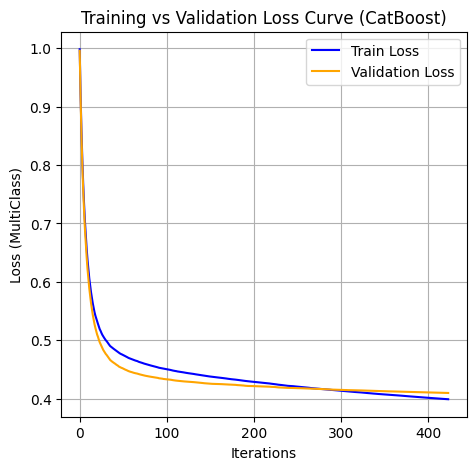

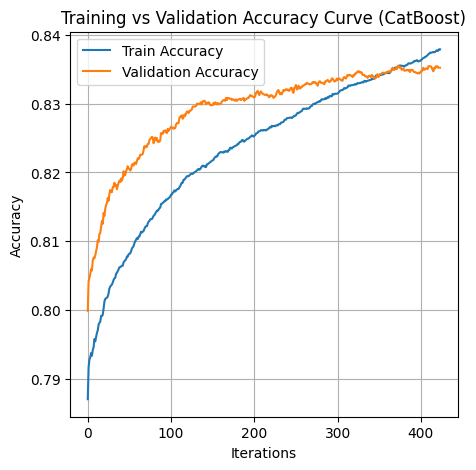


 Final Test Accuracy: 0.8288495760494086

 Final Test Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.69      0.71      2091
           1       0.90      0.92      0.91      3770
           2       0.81      0.81      0.81      3692

    accuracy                           0.83      9553
   macro avg       0.81      0.81      0.81      9553
weighted avg       0.83      0.83      0.83      9553



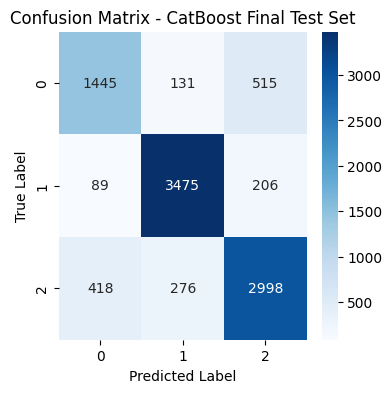

In [ ]:
#@title Catboost Normal Split

print("\n Catboost \n")

# Train--validation-Test Split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val,X_test,y_val,y_test = train_test_split(
    X_temp,y_temp, test_size=0.5 ,stratify=y_temp, random_state=42
)


# Define CatBoost Pools
train_pool = Pool(X_train, label=y_train, text_features=[0])
val_pool = Pool(X_val , label=y_val, text_features=[0])
test_pool = Pool(X_test, label=y_test, text_features=[0])

# Train the model
model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.1,
    early_stopping_rounds=50,
    depth=6,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    verbose=50,
    text_features=[0],
    random_seed=42,
    task_type="GPU",
    devices='0',
)

model.fit(train_pool, eval_set=val_pool)

# Get Learning Curves
metrics = model.get_evals_result()
train_accuracy = metrics['learn']['Accuracy']

val_accuracy = metrics['validation']['Accuracy']
train_loss = metrics['learn']['MultiClass']
val_loss = metrics['validation']['MultiClass']

# Plot Loss Curve
plt.figure(figsize=(5.23, 5))
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel("Iterations")
plt.ylabel("Loss (MultiClass)")
plt.title("Training vs Validation Loss Curve (CatBoost)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(5,5))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy Curve (CatBoost)')
plt.legend()
plt.grid()
plt.show()

# Predict and Evaluate
y_pred = model.predict(test_pool).ravel()

print("\n Final Test Accuracy:", accuracy_score(y_test, y_pred))
print("\n Final Test Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - CatBoost Final Test Set')
plt.show()



 Catboost 


====\n Fold 1/5
====
0:	learn: 0.7885099	test: 0.7980686	best: 0.7980686 (0)	total: 20.6ms	remaining: 20.6s
50:	learn: 0.8105716	test: 0.8160477	best: 0.8160477 (49)	total: 749ms	remaining: 13.9s
100:	learn: 0.8180890	test: 0.8227997	best: 0.8227997 (100)	total: 1.29s	remaining: 11.4s
150:	learn: 0.8229371	test: 0.8257832	best: 0.8259402 (148)	total: 1.83s	remaining: 10.3s
200:	learn: 0.8265094	test: 0.8265683	best: 0.8274319 (180)	total: 2.34s	remaining: 9.3s
250:	learn: 0.8295713	test: 0.8288451	best: 0.8288451 (250)	total: 2.88s	remaining: 8.6s
300:	learn: 0.8321818	test: 0.8298657	best: 0.8301798 (297)	total: 4.47s	remaining: 10.4s
350:	learn: 0.8347923	test: 0.8308864	best: 0.8313575 (342)	total: 6.63s	remaining: 12.3s
400:	learn: 0.8370495	test: 0.8309649	best: 0.8314360 (359)	total: 7.22s	remaining: 10.8s
bestTest = 0.8314359739
bestIteration = 359
Shrink model to first 360 iterations.


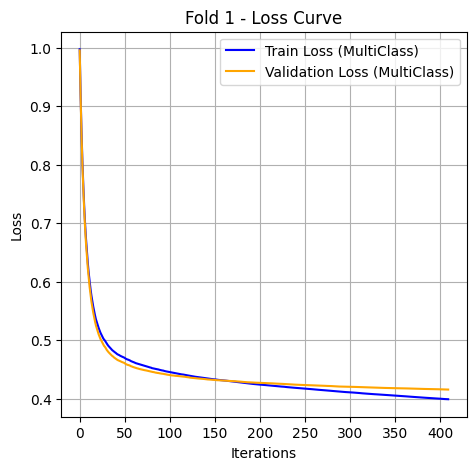

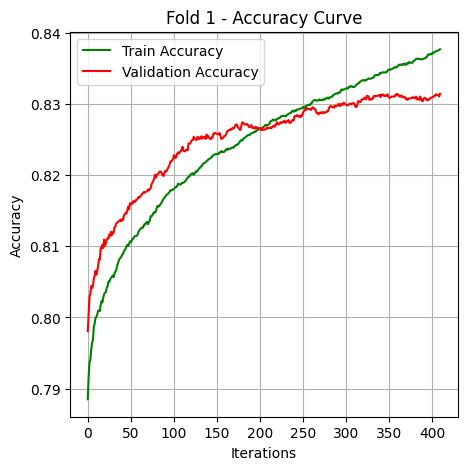


 Fold 1 Test Accuracy: 0.8314

 Fold Test Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.69      0.73      2787
           1       0.89      0.92      0.91      5027
           2       0.80      0.82      0.81      4923

    accuracy                           0.83     12737
   macro avg       0.82      0.81      0.81     12737
weighted avg       0.83      0.83      0.83     12737



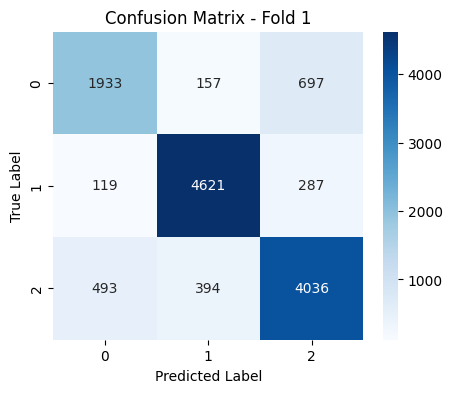


====\n Fold 2/5
====
0:	learn: 0.7927495	test: 0.7964199	best: 0.7964199 (0)	total: 54.4ms	remaining: 54.4s
50:	learn: 0.8117100	test: 0.8128288	best: 0.8128288 (50)	total: 815ms	remaining: 15.2s
100:	learn: 0.8199341	test: 0.8180890	best: 0.8180890 (100)	total: 1.38s	remaining: 12.3s
150:	learn: 0.8244485	test: 0.8213080	best: 0.8217791 (145)	total: 1.95s	remaining: 10.9s
200:	learn: 0.8277459	test: 0.8240559	best: 0.8242914 (197)	total: 3.7s	remaining: 14.7s
250:	learn: 0.8310238	test: 0.8252336	best: 0.8252336 (246)	total: 5.7s	remaining: 17s
300:	learn: 0.8335754	test: 0.8265683	best: 0.8265683 (300)	total: 6.26s	remaining: 14.5s
350:	learn: 0.8367551	test: 0.8269608	best: 0.8273534 (346)	total: 6.76s	remaining: 12.5s
400:	learn: 0.8385609	test: 0.8286881	best: 0.8286881 (394)	total: 7.29s	remaining: 10.9s
450:	learn: 0.8407003	test: 0.8304938	best: 0.8308079 (447)	total: 7.79s	remaining: 9.48s
bestTest = 0.8308078825
bestIteration = 447
Shrink model to first 448 iterations.


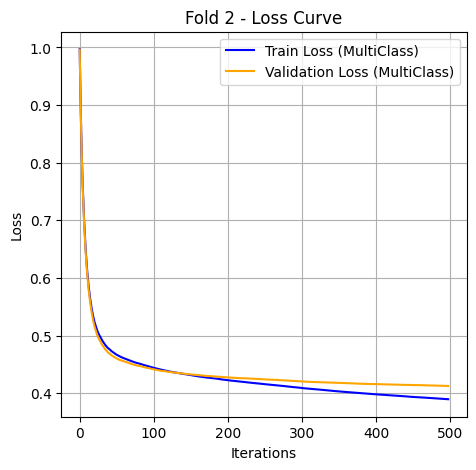

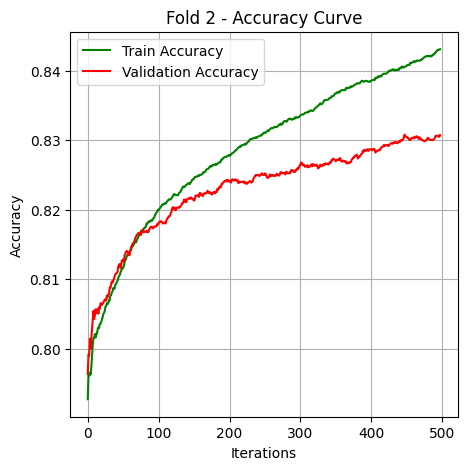


 Fold 2 Test Accuracy: 0.8308

 Fold Test Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.71      0.73      2787
           1       0.89      0.91      0.90      5027
           2       0.80      0.82      0.81      4923

    accuracy                           0.83     12737
   macro avg       0.82      0.81      0.82     12737
weighted avg       0.83      0.83      0.83     12737



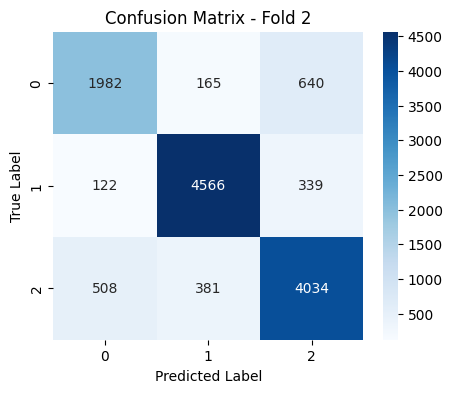


====\n Fold 3/5
====
0:	learn: 0.7863508	test: 0.7986182	best: 0.7986182 (0)	total: 68.7ms	remaining: 1m 8s
50:	learn: 0.8093939	test: 0.8191882	best: 0.8191882 (50)	total: 2.84s	remaining: 52.9s
100:	learn: 0.8169702	test: 0.8246840	best: 0.8247625 (97)	total: 3.45s	remaining: 30.7s
150:	learn: 0.8211902	test: 0.8274319	best: 0.8274319 (150)	total: 4s	remaining: 22.5s
200:	learn: 0.8249588	test: 0.8315930	best: 0.8315930 (200)	total: 4.52s	remaining: 18s
250:	learn: 0.8286488	test: 0.8330847	best: 0.8331632 (222)	total: 5.08s	remaining: 15.2s
300:	learn: 0.8321229	test: 0.8342624	best: 0.8347335 (270)	total: 5.62s	remaining: 13.1s
350:	learn: 0.8344979	test: 0.8350475	best: 0.8352045 (323)	total: 6.13s	remaining: 11.3s
bestTest = 0.8352045223
bestIteration = 323
Shrink model to first 324 iterations.


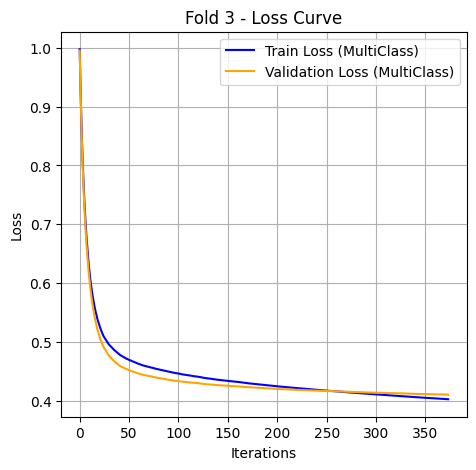

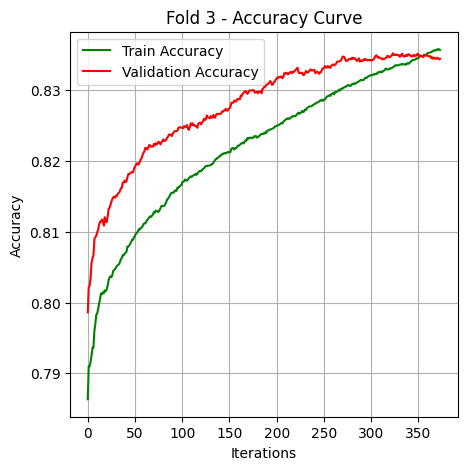


 Fold 3 Test Accuracy: 0.8352

 Fold Test Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.70      0.73      2787
           1       0.90      0.92      0.91      5027
           2       0.81      0.82      0.82      4923

    accuracy                           0.84     12737
   macro avg       0.82      0.82      0.82     12737
weighted avg       0.83      0.84      0.83     12737



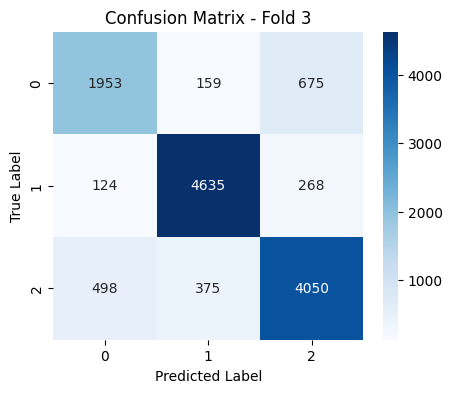


====\n Fold 4/5
====
0:	learn: 0.7847413	test: 0.7993248	best: 0.7993248 (0)	total: 67.6ms	remaining: 1m 7s
50:	learn: 0.8078433	test: 0.8208369	best: 0.8209940 (49)	total: 1.7s	remaining: 31.7s
100:	learn: 0.8156159	test: 0.8260187	best: 0.8261757 (99)	total: 2.24s	remaining: 20s
150:	learn: 0.8217202	test: 0.8315930	best: 0.8315930 (150)	total: 2.78s	remaining: 15.6s
200:	learn: 0.8252728	test: 0.8312004	best: 0.8315930 (150)	total: 3.29s	remaining: 13.1s
bestTest = 0.8315929968
bestIteration = 150
Shrink model to first 151 iterations.


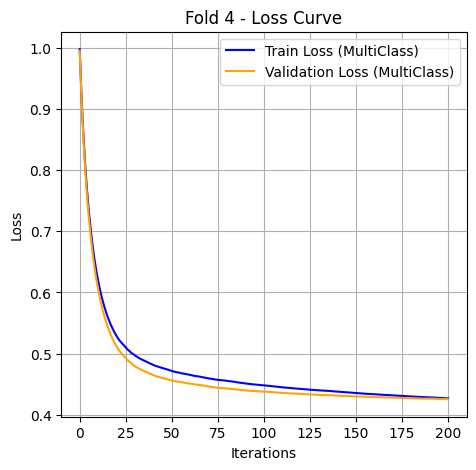

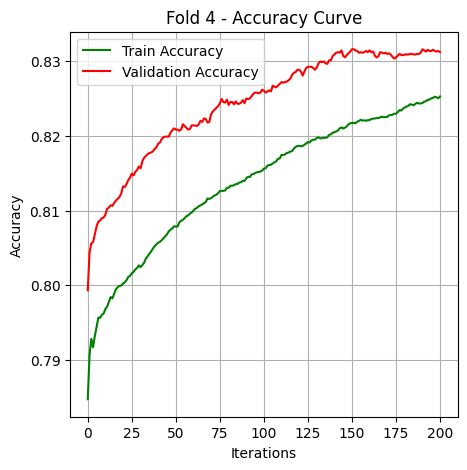


 Fold 4 Test Accuracy: 0.8316

 Fold Test Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.72      0.74      2787
           1       0.89      0.91      0.90      5028
           2       0.81      0.81      0.81      4922

    accuracy                           0.83     12737
   macro avg       0.82      0.81      0.82     12737
weighted avg       0.83      0.83      0.83     12737



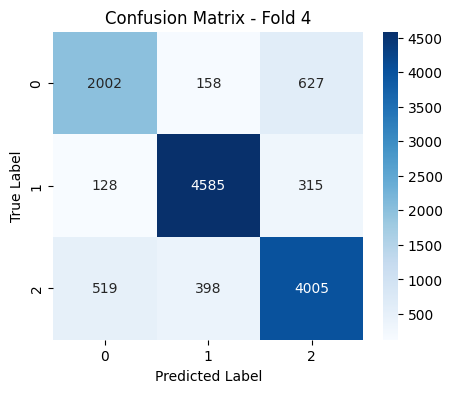


====\n Fold 5/5
====
0:	learn: 0.7897268	test: 0.7974405	best: 0.7974405 (0)	total: 22.1ms	remaining: 22.1s
50:	learn: 0.8120829	test: 0.8152626	best: 0.8152626 (50)	total: 1.41s	remaining: 26.2s
100:	learn: 0.8194237	test: 0.8194237	best: 0.8195022 (89)	total: 3.71s	remaining: 33s
150:	learn: 0.8248803	test: 0.8219361	best: 0.8224857 (146)	total: 4.59s	remaining: 25.8s
200:	learn: 0.8284133	test: 0.8246055	best: 0.8246055 (200)	total: 5.13s	remaining: 20.4s
250:	learn: 0.8314556	test: 0.8257046	best: 0.8258617 (249)	total: 5.65s	remaining: 16.9s
300:	learn: 0.8345568	test: 0.8273534	best: 0.8273534 (300)	total: 6.19s	remaining: 14.4s
350:	learn: 0.8366962	test: 0.8285311	best: 0.8288451 (339)	total: 6.69s	remaining: 12.4s
400:	learn: 0.8386198	test: 0.8297872	best: 0.8300228 (387)	total: 7.22s	remaining: 10.8s
450:	learn: 0.8411321	test: 0.8309649	best: 0.8309649 (450)	total: 7.74s	remaining: 9.42s
500:	learn: 0.8433305	test: 0.8308864	best: 0.8317500 (477)	total: 8.28s	remaining: 8.

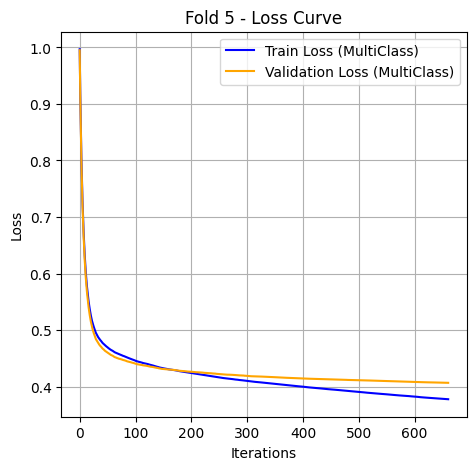

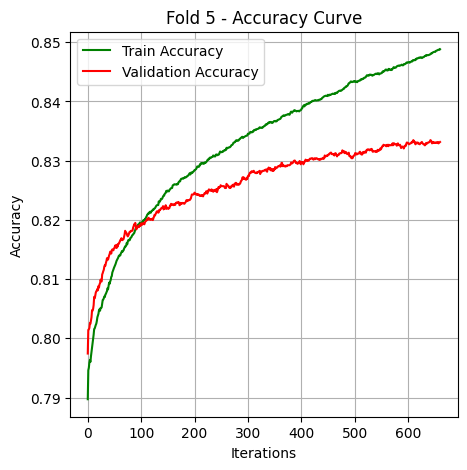


 Fold 5 Test Accuracy: 0.8335

 Fold Test Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.70      0.73      2787
           1       0.90      0.92      0.91      5028
           2       0.81      0.82      0.81      4922

    accuracy                           0.83     12737
   macro avg       0.82      0.81      0.82     12737
weighted avg       0.83      0.83      0.83     12737



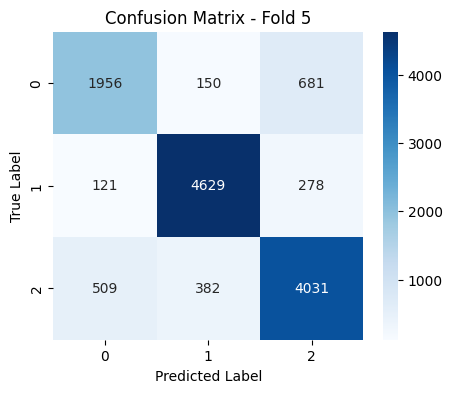

In [ ]:
#@title Catboost Kfolds split

print("\n Catboost \n")

# Stratified K-Fold Setup
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Holders for results
fold_accuracies = []
fold_confusions = []

# Start Cross-Validation Loop
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n====\\n Fold {fold_idx+1}/{n_splits}\n====")

    # Split Data
    X_train_fold = X.iloc[train_idx]
    X_val_fold = X.iloc[val_idx]
    y_train_fold = y.iloc[train_idx]
    y_val_fold = y.iloc[val_idx]

    # Create CatBoost Pools
    train_pool = Pool(X_train_fold, label=y_train_fold, text_features=[0])
    val_pool = Pool(X_val_fold, label=y_val_fold, text_features=[0])

    # Initialize CatBoostClassifier
    model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    early_stopping_rounds=50,
    #class_weights=class_weights,
    task_type="GPU",
    devices='0' ,
    text_features=[0],
    random_seed=42,
    verbose=50
    )


    # Train Model
    model.fit(train_pool, eval_set=val_pool)

    # Evaluate Training and Validation Metrics
    metrics = model.get_evals_result()

    train_accuracy = metrics['learn']['Accuracy']
    val_accuracy = metrics['validation']['Accuracy']
    train_loss = metrics['learn']['MultiClass']
    val_loss = metrics['validation']['MultiClass']

    # Plot Loss Curves
    plt.figure(figsize=(5.23, 5))
    plt.plot(train_loss, label='Train Loss (MultiClass)', color='blue')
    plt.plot(val_loss, label='Validation Loss (MultiClass)', color='orange')
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title(f"Fold {fold_idx+1} - Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Accuracy Curves
    plt.figure(figsize=(5, 5))
    plt.plot(train_accuracy, label='Train Accuracy', color='green')
    plt.plot(val_accuracy, label='Validation Accuracy', color='red')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title(f"Fold {fold_idx+1} - Accuracy Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Make Predictions
    y_pred_fold = model.predict(val_pool).ravel()

    # Calculate Accuracy
    acc = accuracy_score(y_val_fold, y_pred_fold)
    fold_accuracies.append(acc)

    print(f"\n Fold {fold_idx+1} Test Accuracy: {acc:.4f}")
    print("\n Fold Test Classification Report:\n")
    print(classification_report(y_val_fold, y_pred_fold))

    # Confusion Matrix
    cm = confusion_matrix(y_val_fold, y_pred_fold)
    fold_confusions.append(cm)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - Fold {fold_idx+1}')
    plt.show()

    # Save the model for this fold
    model.save_model(f"catboost_fold_{fold_idx+1}.cbm")





 Average Cross-Validation Accuracy across 5 folds: 0.8325
 Overall Cross-Validation Accuracy:  ± 0.0016


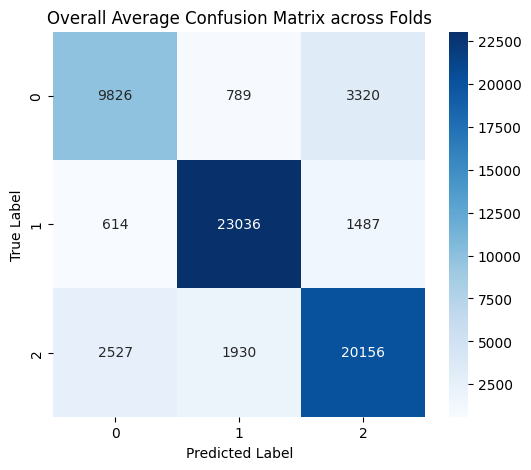

In [ ]:
# After All Folds
# Print Average Accuracy
avg_accuracy = np.mean(fold_accuracies)
print(f"\n Average Cross-Validation Accuracy across {n_splits} folds: {avg_accuracy:.4f}")
std_accuracy = np.std(fold_accuracies)
print(f" Overall Cross-Validation Accuracy:  ± {std_accuracy:.4f}")

# Plot Overall Confusion Matrix
final_cm = sum(fold_confusions)

plt.figure(figsize=(6, 5))
sns.heatmap(final_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Overall Average Confusion Matrix across Folds')
plt.show()

##  Model 2 -  XGBOOST


 Xgboost 

[0]	validation_0-mlogloss:1.09128	validation_0-merror:0.37423	validation_1-mlogloss:1.09118	validation_1-merror:0.36847
[50]	validation_0-mlogloss:0.88674	validation_0-merror:0.33112	validation_1-mlogloss:0.88401	validation_1-merror:0.32723
[100]	validation_0-mlogloss:0.80132	validation_0-merror:0.31802	validation_1-mlogloss:0.79791	validation_1-merror:0.31393
[150]	validation_0-mlogloss:0.75238	validation_0-merror:0.30656	validation_1-mlogloss:0.74857	validation_1-merror:0.30273
[200]	validation_0-mlogloss:0.71955	validation_0-merror:0.29637	validation_1-mlogloss:0.71590	validation_1-merror:0.29268
[250]	validation_0-mlogloss:0.69493	validation_0-merror:0.28792	validation_1-mlogloss:0.69232	validation_1-merror:0.28546
[300]	validation_0-mlogloss:0.67517	validation_0-merror:0.28076	validation_1-mlogloss:0.67380	validation_1-merror:0.27949
[350]	validation_0-mlogloss:0.65865	validation_0-merror:0.27461	validation_1-mlogloss:0.65856	validation_1-merror:0.27353
[400]	validatio

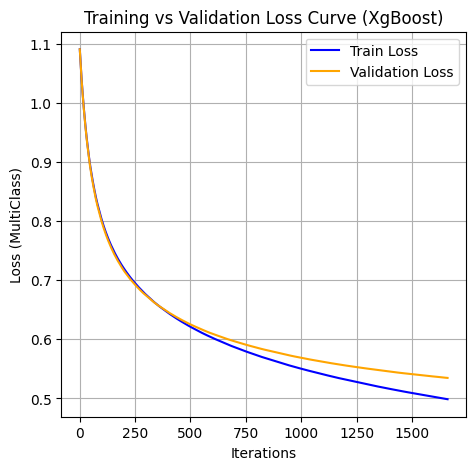

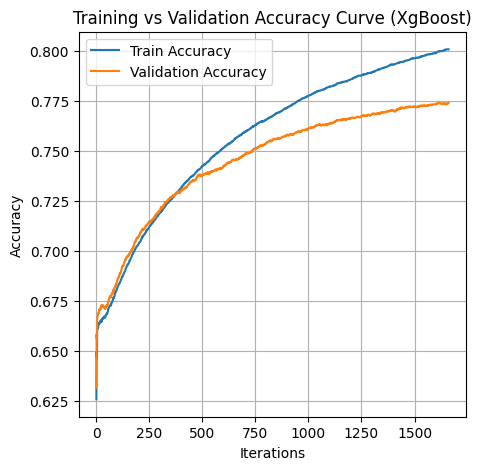


 Final Test Accuracy: 0.7709620014655082

 Final Test Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.46      0.56      2091
           1       0.84      0.90      0.87      3770
           2       0.72      0.81      0.77      3692

    accuracy                           0.77      9553
   macro avg       0.76      0.73      0.73      9553
weighted avg       0.77      0.77      0.76      9553



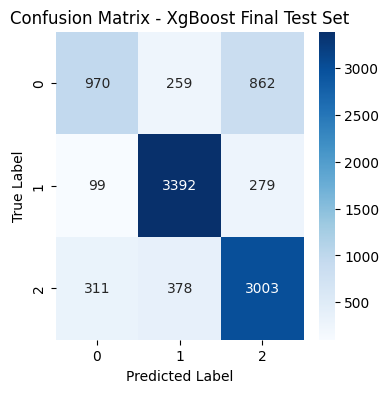

In [ ]:
#@title Xgboost

print("\n Xgboost \n")

# numeric features
X_numeric = fdf[['Year', 'desc_len', 'tit_len']]

# Combine features
X_combined = hstack([X_text, X_numeric])
y = fdf['Genre']

X_train, X_temp, y_train, y_temp = train_test_split(
    X_combined, y, test_size=0.3, stratify=y, random_state=42
)
X_val,X_test,y_val,y_test = train_test_split(
    X_temp,y_temp, test_size=0.5 ,stratify=y_temp, random_state=42
)


# XGBoost Classifier with GPU
model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(y.unique()),
    eval_metric=['mlogloss', 'merror'],
    learning_rate=0.02,
    n_estimators=2000,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=1.0,
    early_stopping_rounds=50,
    tree_method='hist',
    device='cuda',
    verbosity=1
)

# Train the model
model.fit( X_train, y_train, eval_set=[(X_train, y_train),(X_val, y_val)], verbose=50)

# Get Learning Curves
metrics = model.evals_result()
train_loss = metrics['validation_0']['mlogloss']
val_loss = metrics['validation_1']['mlogloss']
train_error = metrics['validation_0']['merror']
val_error = metrics['validation_1']['merror']

# Convert error to accuracy
train_accuracy = [1 - e for e in train_error]
val_accuracy = [1 - e for e in val_error]

# Plot Loss Curve
plt.figure(figsize=(5.22, 5))
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel("Iterations")
plt.ylabel("Loss (MultiClass)")
plt.title("Training vs Validation Loss Curve (XgBoost)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(5,5))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy Curve (XgBoost)')
plt.legend()
plt.grid()
plt.show()

# Predict and Evaluate
y_pred = model.predict(X_test)


print("\n Final Test Accuracy:", accuracy_score(y_test, y_pred))
print("\n Final Test Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - XgBoost Final Test Set')
plt.show()


## Model 3 -  LOGISTIC REGRESSION


 Logistic Regression 


Training Log Loss: 0.4863
Validation Log Loss: 0.5186


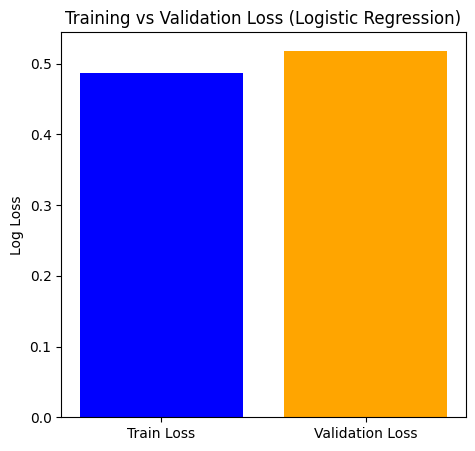

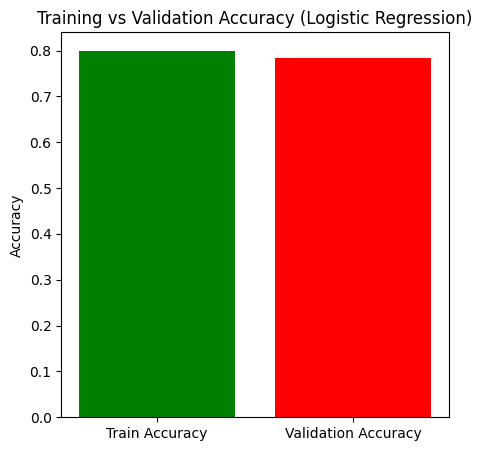


 Final Test Accuracy: 0.7788129383439757

 Final Test Classification Report:

              precision    recall  f1-score   support

           0       0.68      0.55      0.61      2091
           1       0.86      0.90      0.88      3770
           2       0.74      0.78      0.76      3692

    accuracy                           0.78      9553
   macro avg       0.76      0.75      0.75      9553
weighted avg       0.77      0.78      0.77      9553



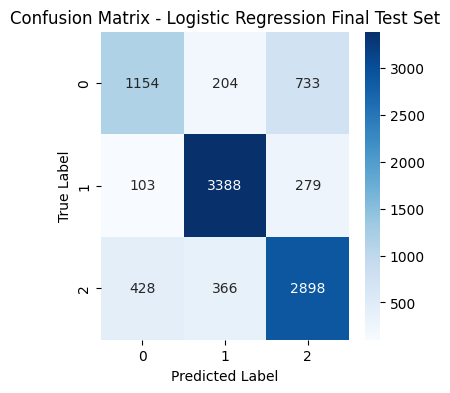

In [ ]:
#@title Logistic Regression

print("\n Logistic Regression \n")

# Labels
y = fdf['Genre']

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(
    X_text, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Initialize Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg.fit(X_train, y_train)

# Predict probabilities (for log loss)
y_train_proba = logreg.predict_proba(X_train)
y_val_proba = logreg.predict_proba(X_val)

# Calculate losses
train_loss = log_loss(y_train, y_train_proba)
val_loss = log_loss(y_val, y_val_proba)

print(f"\nTraining Log Loss: {train_loss:.4f}")
print(f"Validation Log Loss: {val_loss:.4f}")

# Predict class labels on train and val for accuracy
y_train_pred = logreg.predict(X_train)
y_val_pred = logreg.predict(X_val)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Plotting Loss and Accuracy (static since no iterative learning)
plt.figure(figsize=(5.22, 5))
plt.bar(['Train Loss', 'Validation Loss'], [train_loss, val_loss], color=['blue', 'orange'])
plt.ylabel('Log Loss')
plt.title('Training vs Validation Loss (Logistic Regression)')
plt.show()

plt.figure(figsize=(5, 5))
plt.bar(['Train Accuracy', 'Validation Accuracy'], [train_accuracy, val_accuracy], color=['green', 'red'])
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (Logistic Regression)')
plt.show()

# Final evaluation on test set
y_test_pred = logreg.predict(X_test)

print("\n Final Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\n Final Test Classification Report:\n")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression Final Test Set')
plt.show()


</details>

</details>
